In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from ultralytics import YOLO

from utils import db, models, dataset, common
from utils.models import Detector, EmbeddingModel


def get_catd_info(embeds, topk=1):
    pass

def make_dataset(df_path):
    X_train = pd.read_csv(df_path)
    id_list = X_train["id"].tolist()
    prefix = "datasets/card_images_small/"
    id_list = list(map(lambda x: prefix + str(x) + ".jpg", id_list))
    card_type = list(
        map(lambda x: x.lower().startswith("pendulum"), X_train["type"].tolist())
    )
    return dataset.DecklistDataset(id_list, card_type, 1)

In [4]:
# variabels
batch_size = 8
chroma_db = db.ChromaDB()

# load model
student_model = models.Detector()
student_model.load("last.pt")
student_model = student_model.cuda()
student_model.eval()

# train_dataset
train_dataset = make_dataset("datasets/train.csv")
train_loader = DataLoader(
    train_dataset, batch_size, shuffle=True, collate_fn=train_dataset.collate_fn
)

# valid_dataset
# valid_dataset = make_dataset("datasets/valid.csv")
# valid_loader = DataLoader(
#     valid_dataset, batch_size, shuffle=True, collate_fn=valid_dataset.collate_fn
# )

In [5]:
total_image_count = 0
student_embeddings = []
device = next(student_model.parameters()).device

for val_data in train_loader:
    student_inputs = common.detector_preprocessing(val_data["image"]).to(device)
    with torch.no_grad():
        pred_det, pred_embed = student_model(student_inputs)
    if len(student_inputs.shape) == 4:
        input_shape = student_inputs.shape[2:4]
    else:
        input_shape = student_inputs.shape[1:3]
    det_results = student_model.postprocess(pred_det, pred_embed, input_shape, val_data["ori_image"])

    for det_result in det_results:
        for embed in det_result.embeds:
            student_embeddings.append(embed)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [7]:
student_embeddings = np.stack(student_embeddings)

In [8]:
tsne = TSNE(n_components=2, perplexity=30)
embedding_2d = tsne.fit_transform(student_embeddings)

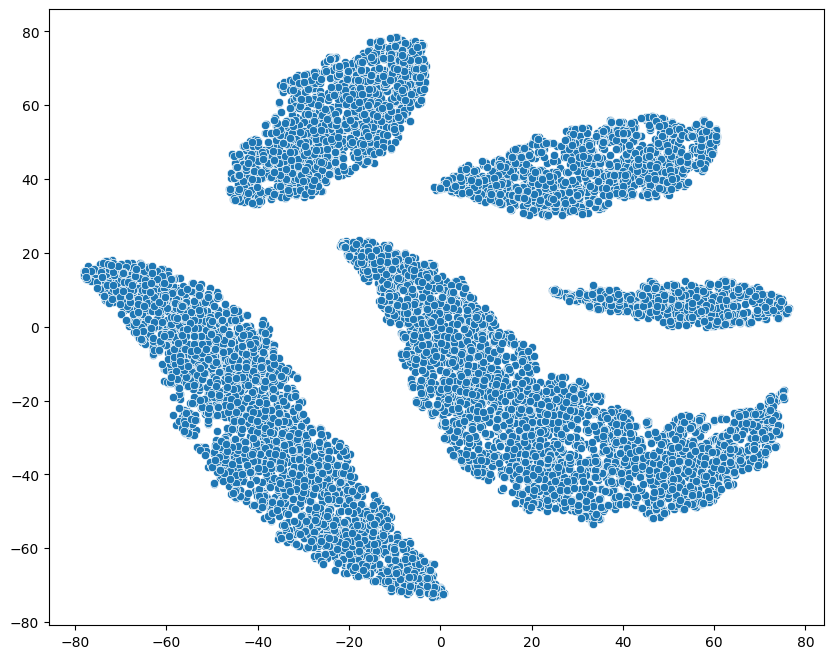

In [9]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1])
plt.show()